# ANN Control using Neural ODEs
We are interested to test out the capabilities of neural network controllers in which a dynamical controller is defined by a neural ODE.

*Currently set up and running, although training does not work.*

In [ ]:
using Flux, DiffEqFlux, DifferentialEquations, Plots
gr()

## Open-loop system
To start out, let's simply simulate the open loop system with Gaussian white noise disturbances using an SDE. The system we consider is a stable second order oscillator of the form:

$\ddot{y}+2\zeta\omega\dot{y} + \omega^2y = P(u + d)$.

To begin with, we consider $u=0$ and $d$ as a white noise disturbance.

In [63]:
function f(du,u,p,t)
    du[1] = u[2]
    du[2] = -2*p[1]*p[2]*u[2] - p[2]^2*u[1]
end
function g(du,u,p,t)
    du[1] = 0.0
    du[2] = p[3]*0.1
end
u0 = Float32[10.; 0.]
tspan = (0.0f0,10.0f0)
prms = [0.1f0,6.0f0,10.0f0]
# prob = SDEProblem(f,g,u0,tspan,prms)
prob = ODEProblem(f,u0,tspan,prms)

ODEProblem with uType Array{Float32,1} and tType Float32. In-place: true
timespan: (0.0f0, 10.0f0)
u0: Float32[10.0, 0.0]

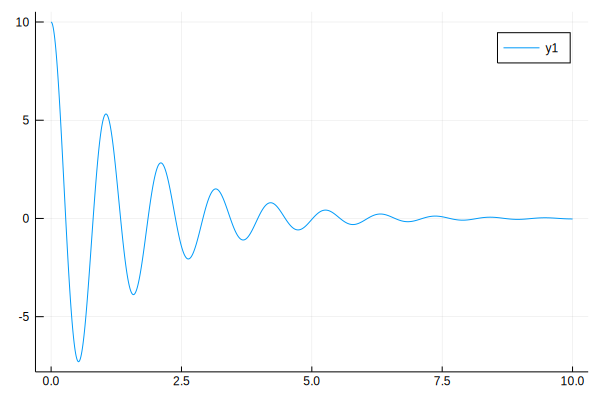

In [64]:
sol = solve(prob, saveat=0.01)
plot(sol.t,sol[1,:])

## Closed-loop system
Now we include a controller in which the input $u$ is described in terms of a differential equation that is a function of $y$, $\dot{y}$:

$\dot{u} = K(y,\dot{y})$

For (negative) derivative feedback, we simply choose $K = -k\dot{y}$.

In [58]:
# K(x,p) = -p[4]*x[1] - p[5]*x[2]
K(x,p) = 2.0*(p[1]-1)*p[2]*x[2]/p[3]
function f(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -2*p[1]*p[2]*x[2] - p[2]^2*x[1] + p[3]*K(x,p)
end
function g(dx,x,p,t)
    dx[1] = 0.0
    dx[2] = p[3]*0.1
end
u0 = Float32[10.; 0.]
tspan = (0.0f0,10.0f0)
prms = [0.1f0,6.0f0,10.0f0]
prob = ODEProblem(f,u0,tspan,prms)

ODEProblem with uType Array{Float32,1} and tType Float32. In-place: true
timespan: (0.0f0, 10.0f0)
u0: Float32[10.0, 0.0]

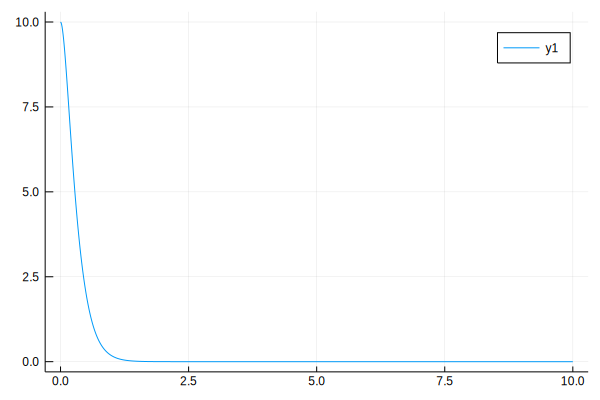

In [59]:
sol = solve(prob, saveat=0.01)
plot(sol.t,sol[1,:])

In [26]:
2*prms[1]*prms[2]/prms[3]

0.120000005f0

## Closed-loop with ANN
We can now replicate the above simulation but replacing $K$ with a neural network.

In [66]:
ann = Chain(Dense(2,10,tanh), Dense(10,1))
ps = Flux.params(ann)
function f(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -2*p[1]*p[2]*x[2] - p[2]^2*x[1] + p[3]*Flux.data(ann(x))[1]
end
function g(dx,x,p,t)
    dx[1] = 0.0
    dx[2] = p[3]*0.1
end
u0 = Float32[10.; 0.]
tspan = (0.0f0,10.0f0)
prms = [0.1f0,6.0f0,10.0f0]
prob = ODEProblem(f,u0,tspan,prms)

ODEProblem with uType Array{Float32,1} and tType Float32. In-place: true
timespan: (0.0f0, 10.0f0)
u0: Float32[10.0, 0.0]

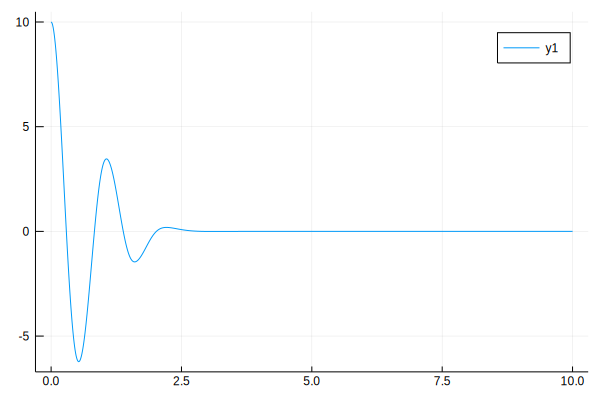

In [67]:
sol = solve(prob, saveat=0.01)
plot(sol.t,sol[1,:])

Define a loss function as the sum od the squared vale over the time-series.

In [68]:
function run_sim(prob,dummy, args...;kwargs...)
    solve(prob, args...; kwargs...) |> Tracker.collect
end
l = 100
t = collect(range(tspan...,length=l))
tmp = x->run_sim(prob,x,saveat=t)

loss() = sum(abs2,zeros(Float32,l) .- tmp(2)[1,:])

loss (generic function with 1 method)

In [92]:
ann = Chain(Dense(2,10,tanh), Dense(10,1))
loss()

500.76147f0 (tracked)

Train!

In [ ]:
cb = function () #callback function to observe training
    display(loss())
end
opt = ADAM(1000.0)
Flux.train!(loss , ps, Iterators.repeated((), 100), opt,cb=cb)

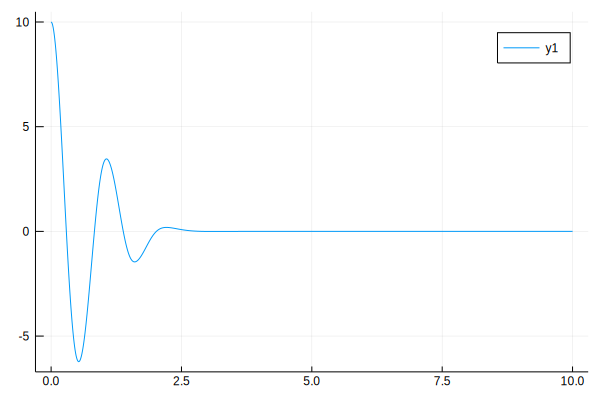

In [74]:
function f(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -2*p[1]*p[2]*x[2] - p[2]^2*x[1] + p[3]*Flux.data(ann(x))[1]
end
prob = ODEProblem(f,u0,tspan,prms)

sol = solve(prob, saveat=0.01)
plot(sol.t,sol[1,:])